<h1 align="center"><font color='#964B00'>Unicité de l'image dans l'ensemble de données</font></h1>
<div style="border-radius:10px; border:#DEB887 solid; background-color: #FFFAF0; font-size:100%; text-align:left">


💡 Notre idée est de sélectionner les images les plus uniques pour chaque classe afin d'assurer la diversité des données labellisées en trois étapes :


1. Extrayons un vecteur de caractéristiques pour chaque image d'entraînement à l'aide du pipeline \textbf{img2vec} __img2vec__ qui vectorise les images à l'aide d'un modèle pré-entraîné (__resnet-18__).

2. Calculons la similarité entre les images à l'aide de la similarité cosinus définie par : 

$$\mathbf{sim}(X, Y) = \frac{\langle X,Y\rangle}{\|X\| \cdot \|Y\|}.$$


3. À l'aide d'une matrice de similarités entre les images, nous définissons l'unicité comme suit 

$$\mathbf{uniqueness}(x_i) = 1 - \sum^{50000}_{j = 1, j\neq i} \mathbf{sim}(x_i, x_j)$$


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle

In [7]:
(x_train, y_train_raw), (x_test, y_test_raw) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train_raw)
y_test = tf.keras.utils.to_categorical(y_test_raw)

In [8]:
def cosine_similarity(x,y):
    '''
    Calcul de la similarité cosinus 
    '''
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

def similarity(imgs_vec):
    ''' 
    input:  Array de vecteurs d'image 
    output: Matrice de similarité pair-wise    
    '''    
    n = imgs_vec.shape[0]
    similarity_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            similarity_matrix[i,j] = cosine_similarity(imgs_vec[i,:],imgs_vec[j,:])
            similarity_matrix[j,i] = similarity_matrix[i,j]
    return similarity_matrix

def uniqueness(similarity_matrix):
    ''' 
    Retourne un array de l'unicité de chaque image 
    '''
    n = similarity_matrix.shape[0]
    uniqueness_ = np.zeros(n)
    for i in range(similarity_matrix.shape[0]):
        uniqueness_[i] = 1 - (np.sum(similarity_matrix[i]) - 1)/(n-1)
    return uniqueness_

def imgs_vectorized(imgs, batch_size = 100) :
    '''
    Embedding images by using pretrained models 
    '''
    n = imgs.shape[0]
    h, w = imgs[0].shape[0], imgs[0].shape[1]
    # Convert array to PIL 
    imgs_PIL = [tf.keras.utils.array_to_img(img) for img in imgs]
    n_batches = int(np.ceil(n / batch_size))
    vector_size = int(h*w/2)
    imgs_vec = np.zeros((n, vector_size))
    for i in range(n_batches):
        # Extract the current batch.
        start = i * batch_size
        end = min(start + batch_size, n)
        imgs_batch = imgs_PIL[start:end]
        imgs_vec_batch = img2vec.get_vec(imgs_batch) 
        imgs_vec[start:end, :] = imgs_vec_batch
    return imgs_vec

In [9]:
class Filter_unique_data():
    def __init__(self,X, y) -> None:
        self.images = X
        self.label = y 
        self.dict_class = {
            0: 'airplane',
            1: 'automobile',
            2: 'bird',
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'frog', 
            7: 'horse', 
            8: 'ship', 
            9: 'truck'
        }
        self.dict_img_10 = {}
        self.dict_img_5 = {}
        self.dict_img_1 = {}
    
    def most_unique_imgs(self, label):
        ''' 
        Trouver les images les plus uniques de chaque classe 

        input:  label = 0...9 
        output: 10% des images les plus uniques 
        '''
        imgs_class = self.images[(self.label ==label).reshape(-1)]
        imgs_vec = imgs_vectorized(imgs_class)
        sim_mat = similarity(imgs_vec)
        img_uniqueness = uniqueness(sim_mat)
        index = np.argsort(img_uniqueness)
        ten_percent_unique_imgs = [imgs_class[i] for i in index[:int(0.1*imgs_vec.shape[0])]]
        return ten_percent_unique_imgs
    
    def generate_unique_dataset(self):
        ''' 
        Trouver les images les plus uniques de toutes les classes
        '''
        for c in self.dict_class.keys(): 
            print(f'Finding unique {self.dict_class[c]}')
            unique_imgs_10 = self.most_unique_imgs(label = c)
            self.dict_img_10[c] = unique_imgs_10
            self.dict_img_5[c] = unique_imgs_10[:int(0.5*len(unique_imgs_10))]
            self.dict_img_1[c] = unique_imgs_10[:int(0.1*len(unique_imgs_10))]

    def save_filtered_dataset(self, bool_shuffle = True):
        for per, d in zip(["10", "5", "1"],[self.dict_img_10, self.dict_img_5, self.dict_img_1]):
            out_imgs, out_label = [], []
            for c in self.dict_class.keys():
                out_imgs += d[c]
                out_label += [c] * len(d[c])
            if bool_shuffle:
                randomize = np.arange(len(out_imgs))
                np.random.shuffle(randomize)
                x, y = np.array(out_imgs)[randomize], np.array(out_label)[randomize]
            else : 
                x, y = np.array(out_imgs), np.array(out_label)
            np.save('new_X_unique_'+per+'.npy', x)
            np.save('new_y_unique_'+per+'.npy', y)
            print(f'new_X_unique_{per}.npy is saved')

In [11]:
from img2vec_pytorch import Img2Vec

# Initializer Img2Vec
img2vec = Img2Vec(cuda=False)

OSError: [WinError 182] The operating system cannot run %1. Error loading "c:\Users\THOOT38J\Anaconda3\envs\deep_learning\lib\site-packages\torch\lib\nvfuser_codegen.dll" or one of its dependencies.

In [ ]:
filter = Filter_unique_data(x_train, y_train_raw)
most_unique_cars = filter.most_unique_imgs(label=1, percent=0.1)

NameError: name 'x_train' is not defined

In [ ]:
filter.generate_unique_dataset()
filter.save_filtered_dataset(bool_shuffle = True)

AttributeError: type object 'filter' has no attribute 'generate_unique_dataset'

In [ ]:
# x, y = np.load('X_unique_1.npy'), np.load('y_unique_1.npy')

In [ ]:
# Affichage des images originales
for i in range(20, 30):
    plt.subplot(2,5,i+1-20)
    plt.imshow(x[i])
    plt.title(filter.dict_class[y[i]])
    plt.grid(False)
    plt.axis('off')

NameError: name 'plt' is not defined

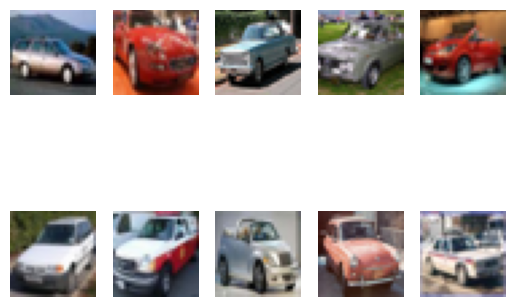

In [ ]:
cats = x_train[(y_train_raw==1).reshape(-1)]
start = 0
for i in range(start, 10):
    plt.subplot(2,5,i+1-start)
    plt.imshow(cats[i])
    # plt.title(dict_class[y[i]])
    plt.grid(False)
    # plt.title('Cosine sim = ' + str(similarity()))
    plt.axis('off')

In [ ]:
cats_vec = imgs_vectorized(x_train[(y_train_raw==1).reshape(-1)][1:11])

/tmp/ipykernel_769463/2500844222.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i)


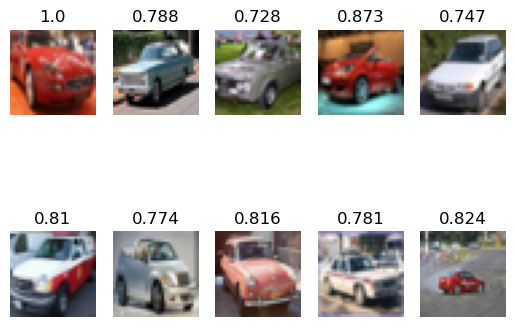

In [ ]:
cats = x_train[(y_train_raw==1).reshape(-1)]
start = 0
plt.imshow(cats[1])
plt.grid(False)
plt.title('Cosine sim = '+str(cosine_similarity(cats_vec[0], cats_vec[0])))
plt.axis('off')
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(cats[i])
    plt.title(str(round(cosine_similarity(cats_vec[0], cats_vec[i-1]), 3)))
    plt.grid(False)
    plt.axis('off')

/tmp/ipykernel_769463/3886314470.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i)


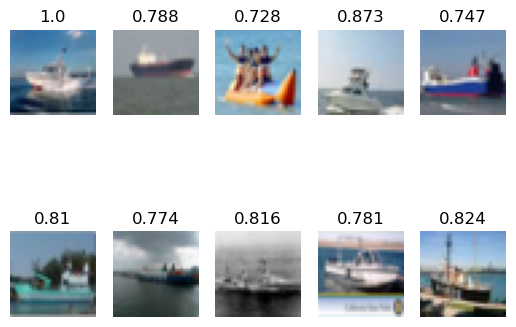

In [ ]:
cats = x_train[(y_train_raw==8).reshape(-1)]
start = 0
plt.imshow(cats[1])
plt.grid(False)
plt.title('Cosine sim = '+str(cosine_similarity(cats_vec[0], cats_vec[0])))
plt.axis('off')
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(cats[i])
    plt.title(r''+str(round(cosine_similarity(cats_vec[0], cats_vec[i-1]), 3)))
    plt.grid(False)
    plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

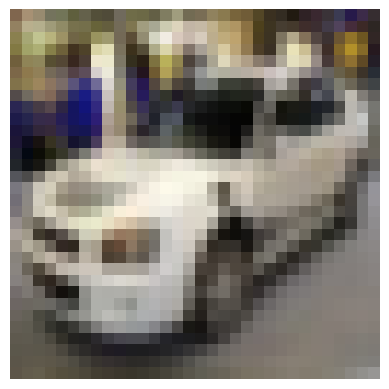

In [ ]:
plt.imshow(cats[7])
# plt.title(dict_class[y[i]])
plt.grid(False)
plt.axis('off')

In [ ]:
all_cats = x_train[(y_train_raw==3).reshape(-1)]

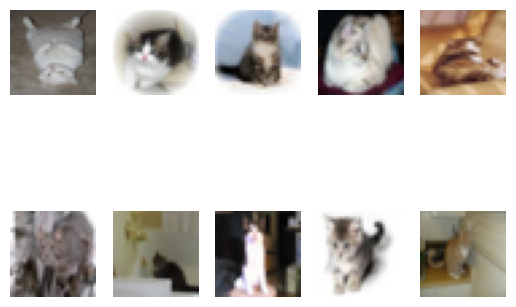

In [ ]:
for i in range(20, 30):
    plt.subplot(2,5,i+1-20)
    plt.imshow(all_cats[i])
    # plt.title(dict_class[y[i]])
    plt.grid(False)
    plt.axis('off')

In [ ]:
# np.save('X_unique_'+ str(filter.percent)+'.npy', x)
# np.save('y_unique_'+ str(filter.percent)+'.npy', y)
